In [1]:
import pickle
import glob
import matplotlib.pyplot as plt
from scipy import optimize
import numpy as np
import pandas as pd

In [2]:
idx_tups = []
for file in glob.glob("../../data/texas/texas_20m*"):
    f = pickle.load(open(file, 'rb'))
    accs = []
    advs = []
    merlin_advs = []
    print(len(f), file)
    for fd in f:
        a, y, m = max([(a, yt - yf, mt  - mf) for a, yt, yf, mt, mf in zip(fd['acc'], fd['yeom_tpr'], fd['yeom_fpr'], fd['merlin_tpr'], fd['merlin_fpr'])]) #[-1]
        fd['acc'] = a
        fd['adv'] = y
        fd['merlin_adv'] = m
        accs.append(a)
        advs.append(y)
        merlin_advs.append(m)

    
    var = file.split("_")[-5:]
    if var[-5] == '20mb' or var[-5] == 'mb':
        var[-5] = 'dp'
    else:
        var[-5] = 'is'
    var[-4] = int(var[-4])
    var[-1] = int(var[-1].split(".")[0])
    var[-3] = int(var[-3])
    var[-2] = float(var[-2]) if var[-2] != 'False' else False
    
    var.append(np.mean(accs))
    var.append(np.max(accs))
    var.append(np.mean(advs))
    var.append(np.max(advs))
    var.append(np.mean(merlin_advs))
    var.append(np.std(accs))
    var.append(np.std(advs))
    var.append(np.std(merlin_advs))
    # IDX tups follow the format (epsilon, throw out threshold, batch size)
    idx_tups.append(var)

20 ../../data/texas/texas_20m_256_0_5_64.b
20 ../../data/texas/texas_20mb_128_100000_0.2_64.b
20 ../../data/texas/texas_20m_128_10_0_64.b
20 ../../data/texas/texas_20m_256_50000_5_64.b
20 ../../data/texas/texas_20mb_128_1000000_0.2_64.b
20 ../../data/texas/texas_20m_128_75000_0_64.b
20 ../../data/texas/texas_20m_128_500000_5_64.b
20 ../../data/texas/texas_20mb_128_250000_0.2_64.b
20 ../../data/texas/texas_20mb_256_250000_0.2_64.b
20 ../../data/texas/texas_20m_256_1000_5_64.b
20 ../../data/texas/texas_20m_256_1000_0_64.b
20 ../../data/texas/texas_20m_128_1_0_64.b
20 ../../data/texas/texas_20mb_256_1000000_0.2_64.b
20 ../../data/texas/texas_20mb_256_500000_0.2_64.b
20 ../../data/texas/texas_20mb_256_100_0.2_64.b
20 ../../data/texas/texas_20mb_128_50000_0.2_64.b
20 ../../data/texas/texas_20m_128_50000_0_64.b
20 ../../data/texas/texas_20m_128_0_5_64.b
20 ../../data/texas/texas_20mb_256_50000_0.2_64.b
20 ../../data/texas/texas_20m_256_500000_5_64.b
20 ../../data/texas/texas_20m_256_10_5_64.

In [3]:
ds = pd.DataFrame(idx_tups)
ds.columns = ['method','width', 'epsilon', 'throw out', 'batch_size', 'acc','max_acc', 'yeom','max_yeom', 'merlin', 'acc_std', 'yeom_std', 'merlin_std']

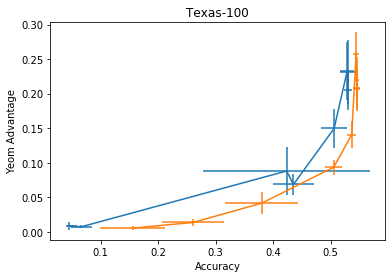

In [4]:
dps = ds[(ds['method'] == 'dp') & (ds['width'] == 256) & (ds['acc'] > 0)].sort_values('acc')
i0 = ds[(ds['method'] == 'is') & (ds['epsilon'] != 0) & (ds['width'] == 256) & (ds['throw out'] == 0) & (ds['acc'] > 0)].sort_values('acc')
i5 = ds[(ds['method'] == 'is') & (ds['epsilon'] != 0) & (ds['width'] == 256) & (ds['throw out'] == 5)].sort_values('acc')
i10 = ds[(ds['method'] == 'is') & (ds['epsilon'] != 0) & (ds['width'] == 256) & (ds['throw out'] == 10)].sort_values('acc')

plt.errorbar(dps['acc'], dps['yeom'], yerr=dps['yeom_std'], xerr=dps['acc_std'])
plt.errorbar(i0['acc'], i0['yeom'], yerr=i0['yeom_std'], xerr=i0['acc_std'])
#plt.errorbar(dps['yeom'], dps['acc'], dps['acc_std'])
#plt.errorbar(i0['yeom'], i0['acc'], i0['acc_std'])



#plt.plot(dps['acc'], dps['yeom'])
#plt.plot(i0['acc'], i0['yeom'])

#plt.scatter(i10['acc'], i10['yeom'])
#plt.scatter(base['acc'], base['yeom'], color='g')
plt.xlabel('Accuracy')
plt.title('Texas-100')
plt.ylabel('Yeom Advantage')
fig = plt.gcf()
#fig.set_size_inches(4, 4)
plt.savefig('/home/ubuntu/6058f04dd79997b3e3ffcbad/figures/texas_acc_adv.png', dpi=400)

In [8]:
dps.sort_values('acc_std', ascending=False)

,method,width,epsilon,throw out,batch_size,acc,max_acc,yeom,max_yeom,merlin,acc_std,yeom_std,merlin_std
55,dp,256,100000,0.2,64,0.423498,0.511218,0.088012,0.126361,0.092500,0.144981,0.034501,0.036169
18,dp,256,50000,0.2,64,0.435387,0.483173,0.068633,0.086347,0.064180,0.035513,0.014652,0.024649
8,dp,256,250000,0.2,64,0.506090,0.536258,0.149656,0.207974,0.123828,0.023112,0.028773,0.040231
46,dp,256,1000,0.2,64,0.066847,0.102364,0.007353,0.012753,0.092266,0.017847,0.002311,0.037483
43,dp,256,2000000,0.2,64,0.530018,0.550080,0.231433,0.359965,0.142930,0.013360,0.046711,0.027372
12,dp,256,1000000,0.2,64,0.528826,0.547276,0.232950,0.334945,0.171016,0.012580,0.042337,0.038090
14,dp,256,100,0.2,64,0.050761,0.075721,0.008091,0.013045,0.106758,0.008194,0.002448,0.050289
13,dp,256,500000,0.2,64,0.530148,0.542067,0.205269,0.262646,0.160078,0.007577,0.028239,0.049739
33,dp,256,1,0.2,64,0.045383,0.057492,0.008660,0.019067,0.074727,0.005943,0.005697,0.031442


In [4]:
def plot_noise_results(df, base=None, title="", ax1 = None):
    epsilons = df['epsilon']
    acc = df['acc']
    acc_std = df['acc_std']
    adv = df['yeom']
    adv_std = df['yeom_std']
    
    if base is not None:
        base_acc = [float(base['acc']) for i in epsilons]    
        base_acc_std = [float(base['acc_std']) for i in epsilons]
        base_adv = [float(base['yeom']) for i in epsilons]
        base_adv_std = [float(base['yeom_std']) for i in epsilons]
    plt.figure()

    if ax1 is None:
        ax1 = plt.gca()
        
    markers, caps, bars = ax1.errorbar(epsilons, 
                                       acc, 
                                       acc_std, 
                                       color='b', 
                                       alpha=.8)
    [bar.set_alpha(0.25) for bar in bars]
    [cap.set_alpha(0.25) for cap in caps]
    ax1.set_ylabel('Accuracy', color='b')
    ax1.tick_params('x', colors='b')
    
    if base is not None:
            markers, caps, bars = ax1.errorbar(epsilons, 
                                       base_acc, 
                                       base_acc_std, 
                                       fmt='--',
                                       color='b', 
                                       alpha=.8)
            [bar.set_alpha(0.25) for bar in bars]
            [cap.set_alpha(0.25) for cap in caps]

    ax2 = ax1.twinx()
    markers, caps, bars = ax2.errorbar(epsilons, 
                                       adv, 
                                       adv_std, 
                                       color='r')
    [bar.set_alpha(0.25) for bar in bars]
    [cap.set_alpha(0.25) for cap in caps]
    ax2.set_ylabel('Membership Inference Adv', color='r')
    ax2.tick_params('x', colors='r')
    
    if base is not None:
            markers, caps, bars = ax2.errorbar(epsilons, 
                                       base_adv, 
                                       base_adv_std,
                                       fmt='--',
                                       color='r', 
                                       alpha=.8)
            [bar.set_alpha(0.25) for bar in bars]
            [cap.set_alpha(0.25) for cap in caps]

    ax1.set_xlabel('Epsilon (delta = 1e-5)')
    ax1.set_title(title)
    #fig.tight_layout()
    
    plt.xscale('log')
    return ax1, ax2
    #plt.show() 
    
def plot_against_eps(isd, dpd, arg, base=None, title="", ax1 = None):
    is_eps = isd['epsilon']
    dp_eps = dpd['epsilon']
    is_eps = [i/max(is_eps) for i in is_eps]
    dp_eps = [i/max(dp_eps) for i in dp_eps]
    is_arg = isd[arg]
    dp_arg = dpd[arg]
    is_std = isd[f'{arg}_std']
    dp_std = dpd[f'{arg}_std']
    
    if base is not None:
        base_arg = [float(base[arg]) for i in is_eps]    
        base_std = [float(base[f'{arg}_std']) for i in is_eps]
        
    markers, caps, bars = ax1.errorbar(is_eps, 
                                       is_arg, 
                                       is_std, 
                                       color='r')
    [bar.set_alpha(0.25) for bar in bars]
    [cap.set_alpha(0.25) for cap in caps]
    
    markers, caps, bars = ax1.errorbar(dp_eps, 
                                       dp_arg, 
                                       dp_std, 
                                       color='blue')
    [bar.set_alpha(0.25) for bar in bars]
    [cap.set_alpha(0.25) for cap in caps]
    
    if base is not None:
        markers, caps, bars = ax1.errorbar(is_eps, 
                                    base_arg, 
                                    base_std,
                                    fmt='--',
                                    color='black', 
                                    alpha=.8)
        [bar.set_alpha(0.25) for bar in bars]
        [cap.set_alpha(0.25) for cap in caps]
        return ax1
    
    

In [5]:
dps = ds[(ds['method'] == 'dp') & (ds['width'] == 256) & (ds['epsilon'] <= 1000000) & (ds['yeom'] < .3)].sort_values('epsilon')
iss = ds[(ds['method'] == 'is') & (ds['epsilon'] != 0) & (ds['epsilon'] < 100000) & (ds['width'] == 256) & (ds['throw out'] == 0) & (ds['yeom'] < .3)].sort_values('epsilon')
base = ds[(ds['epsilon'] == 0) & (ds['width'] == 256) & (ds['throw out'] == 0)]
base

,method,width,epsilon,throw out,batch_size,acc,yeom,merlin,acc_std,yeom_std,merlin_std
31,is,256,0,0.0,64,0.537109,0.274325,0.156719,0.004411,0.052738,0.033637


(0.06, 0.6)

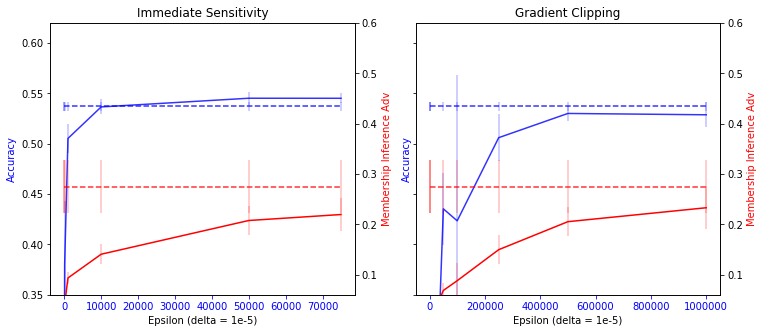

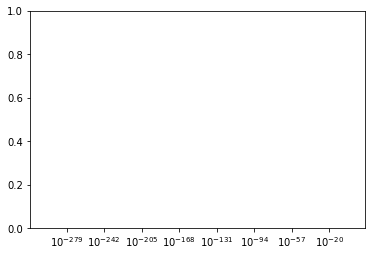

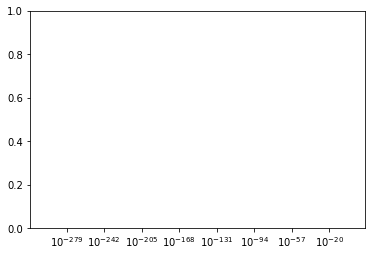

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
fig.set_size_inches(12, 5)
x1, x2 = plot_noise_results(iss, base, 'Immediate Sensitivity', ax1)
x3, x4 = plot_noise_results(dps, base, 'Gradient Clipping', ax2)

x1.set_ylim(.35, .62)
x3.set_ylim(.35, .62)
x2.set_ylim(.06, .60)
x4.set_ylim(.06, .60)

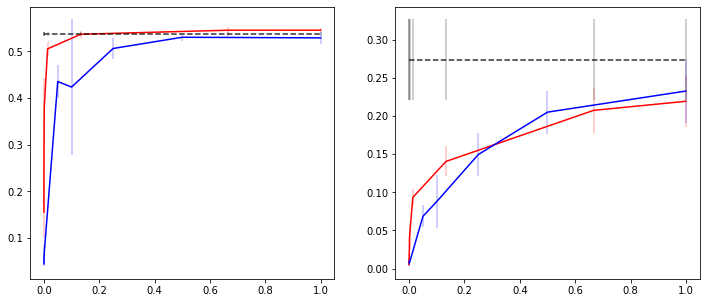

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=False)
fig.set_size_inches(12, 5)
x1= plot_against_eps(iss, dps,'acc', base=base, title='Accuracy', ax1=ax1)
x2 = plot_against_eps(iss, dps,'yeom', base=base, title='Advantage', ax1=ax2)

In [9]:
max(dps['acc'])
max(i0['acc'])

0.5452624198717949

In [10]:
dps[dps['yeom'] > .08]

,method,width,epsilon,throw out,batch_size,acc,yeom,merlin,acc_std,yeom_std,merlin_std
54,dp,256,100000,0.2,64,0.423498,0.088012,0.092500,0.144981,0.034501,0.036169
8,dp,256,250000,0.2,64,0.506090,0.149656,0.123828,0.023112,0.028773,0.040231
12,dp,256,1000000,0.2,64,0.528826,0.232950,0.171016,0.012580,0.042337,0.038090
13,dp,256,500000,0.2,64,0.530148,0.205269,0.160078,0.007577,0.028239,0.049739
